<a href="https://colab.research.google.com/github/nwon24/basel/blob/main/Basel_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset,DataLoader,TensorDataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from datetime import date

!pip install pennylane qiskit pennylane-qiskit pylatexenc
import pennylane as qml
from qiskit import QuantumCircuit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file="/content/drive/MyDrive/Colab Notebooks/Basel_2020-23.csv"
file2="/content/drive/MyDrive/Colab Notebooks/Basel_2024-25.csv"

df=pd.read_csv(file,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
df2=pd.read_csv(file2,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
nparr=df.to_numpy(dtype=np.float64)
nparr2=df2.to_numpy(dtype=np.float64)

In [4]:
predwin=8
nqubits=predwin

In [62]:
testhours=365*24
totalhours=nparr.size
train_split=nparr[:-testhours]
test_split=nparr[-testhours:]
valid_split=nparr2


In [63]:
scaler=MinMaxScaler(feature_range=(0,1))
train_data=(torch.from_numpy(scaler.fit_transform(train_split)))
test_data=(torch.from_numpy(scaler.transform(test_split)))
valid_data=(torch.from_numpy(scaler.transform(valid_split)))

In [7]:
def preparexy(data,predwin,horizon):
    n=(len(data)-predwin)//horizon
    x=torch.zeros((n,predwin,1))
    y=torch.zeros((n,horizon,1))
    for i in range(n):
        x[i]=data[i:i+predwin]
        y[i]=data[i+predwin:i+predwin+horizon]
    return x,y

In [33]:
class lstm(nn.Module):
    def __init__(self,inputsize,hiddensize,nlayers,outputsize,batch_first=True,dropout=0.0):
        super().__init__()
        self.inputsize=inputsize
        self.hiddensize=hiddensize
        self.nlayers=nlayers
        self.batch_first=batch_first
        self.outputsize=outputsize
        self.dropout=dropout
        self.lstm=nn.LSTM(self.inputsize,self.hiddensize,self.nlayers,batch_first=self.batch_first,dropout=dropout)
        self.linear=nn.Linear(self.hiddensize,outputsize)

    def forward(self,x):
        out,_=self.lstm(x)
        return self.linear(out[:,-1,:])

In [34]:
inputsize=1
nlayers=1
hiddensize=128
outputsize=horizon

dropout=0.0
model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)

In [9]:
def validate(model,valid_data,xvalid,yvalid,shape,predwin,horizon,start=None,end=None):
    model.eval()
    with torch.no_grad():
        nhours=len(valid_data)
        n=len(xvalid)
        t=np.arange(nhours)
        forecasts=[]
        for i in range(n):
            y=model(xvalid[i].reshape(shape))
            forecasts.append(y.detach().numpy())
        forecasts=np.array(forecasts).flatten()
        transformed_forecasts=scaler.inverse_transform(forecasts.reshape(-1,1))
        transformed_y=scaler.inverse_transform(yvalid.detach().numpy().reshape(-1,1))

        return r2_score(transformed_y,transformed_forecasts), mean_squared_error(transformed_y,transformed_forecasts)

In [57]:
def numparams(model):
    return sum(p.numel() for p in model.parameters())

In [74]:
qpredwin=predwin
nqubits=qpredwin
qdev="lightning.qubit"
dev=qml.device(qdev)

@qml.qnode(dev)
def qnode(inputs,weights):
    qubits=weights.shape[1]
    layers=weights.shape[0]
    for i in range(qubits):
        qml.Hadamard(wires=i)
        qml.RY(inputs[i],wires=i)

    for i in range(layers):
        for j in range(qubits-1):
            qml.CNOT(wires=[j,j+1])
        qml.CNOT(wires=[0,qubits-1])
        for j in range(qubits):
            qml.Rot(*weights[i][j],wires=j)
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [38]:
class qmodel(nn.Module):
    def __init__(self,nqubits,qlayer,outputsize):
        super().__init__()
        self.qlayer=qlayer
        self.nqubits=nqubits
        self.outputsize=outputsize
        self.lin=nn.Linear(nqubits,outputsize)

    def forward(self,x):
        y=self.qlayer(x)
        return self.lin(y)

In [20]:
def loadqnn(nlayers,nqubits,qoutputsize):
    weightshapes={"weights": (nlayers,nqubits,3)}
    qlayer=qml.qnn.TorchLayer(qnode,weightshapes)
    qnn=qmodel(nqubits,qlayer,qoutputsize)
    return qnn

# 1 hour horizon

In [64]:
horizon=1
outputsize=horizon
model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)
xvalid,yvalid=preparexy(valid_data,predwin,horizon)

In [65]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_LSTM_2026-02-04_49e_1h_1l.pth",weights_only=True))
validate(model,valid_data,xvalid,yvalid,(1,-1,1),predwin,horizon,start=None,end=None)

(0.9944174289703369, 0.34546953439712524)

In [58]:
numparams(model)

67201

In [59]:
qhorizon=horizon
qoutputsize=qhorizon

In [60]:
# 5 layers
qnn=loadqnn(5,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-08_49e_1h_5l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

(0.9931974411010742, 0.4209681749343872)

In [61]:
numparams(qnn)

129

In [24]:
# 4 layers
qnn=loadqnn(4,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-07_49e_1h_4l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.9931725263595581, 0.42250943183898926)

In [25]:
# 3 layers
qnn=loadqnn(3,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-06_49e_1h_3l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.9927796125411987, 0.4468250572681427)

In [26]:
# 2 layers
qnn=loadqnn(2,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-05_49e_1h_2l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.9921077489852905, 0.48840415477752686)

In [27]:
# 1 layer
qnn=loadqnn(1,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-05_49e_1h_1l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.9816394448280334, 1.1362237930297852)

# 8 hour horizon

In [35]:
horizon=8
outputsize=horizon
xvalid,yvalid=preparexy(valid_data,predwin,horizon)
model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)

In [36]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_LSTM_2026-02-02_49e_8h_1l.pth",weights_only=True))
validate(model,valid_data,xvalid,yvalid,(1,-1,1),predwin,horizon,start=None,end=None)

(0.721511721611023, 6.745541095733643)

In [40]:
# 5 layers
qhorizon=horizon
qoutputsize=qhorizon
qnn=loadqnn(5,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-03_49e_8h_5l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

(0.7480536699295044, 6.10264253616333)

In [41]:
# 4 layers
qnn=loadqnn(4,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-02_49e_8h_4l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.6783298254013062, 7.791492462158203)

In [42]:
# 3 layers
qnn=loadqnn(3,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-02_49e_8h_3l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.7588850855827332, 5.8402838706970215)

In [43]:
# 2 layers
qnn=loadqnn(2,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-02_49e_8h_2l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.7253015041351318, 6.653744697570801)

In [44]:
# 1 layer
qnn=loadqnn(1,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-02_49e_8h_1l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.6514094471931458, 8.443557739257812)

# 16 hour horizon

In [45]:
horizon=16
outputsize=horizon
xvalid,yvalid=preparexy(valid_data,predwin,horizon)
model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)

In [46]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_LSTM_2026-02-03_49e_16h_1l.pth",weights_only=True))
validate(model,valid_data,xvalid,yvalid,(1,-1,1),predwin,horizon,start=None,end=None)

(0.5887277126312256, 11.553923606872559)

In [47]:
# 5 layers
qhorizon=horizon
qoutputsize=qhorizon
qnn=loadqnn(5,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-03_49e_16h_5l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

(0.6370531320571899, 10.196311950683594)

In [48]:
# 4 layers
qnn=loadqnn(4,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-03_49e_16h_4l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.6766109466552734, 9.08500862121582)

In [50]:
# 3 layers
qnn=loadqnn(3,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-03_49e_16h_3l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.6161341667175293, 10.783990859985352)

In [51]:
# 2 layers
qnn=loadqnn(2,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-03_49e_16h_2l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.6501671075820923, 9.827898979187012)

In [52]:
# 1 layer
qnn=loadqnn(1,nqubits,qoutputsize)
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel pth/Basel_QNN_2026-02-03_49e_16h_1l.pth",weights_only=True))
validate(qnn,valid_data,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)


(0.6196684241294861, 10.684701919555664)

# Quantum circuit visualisation

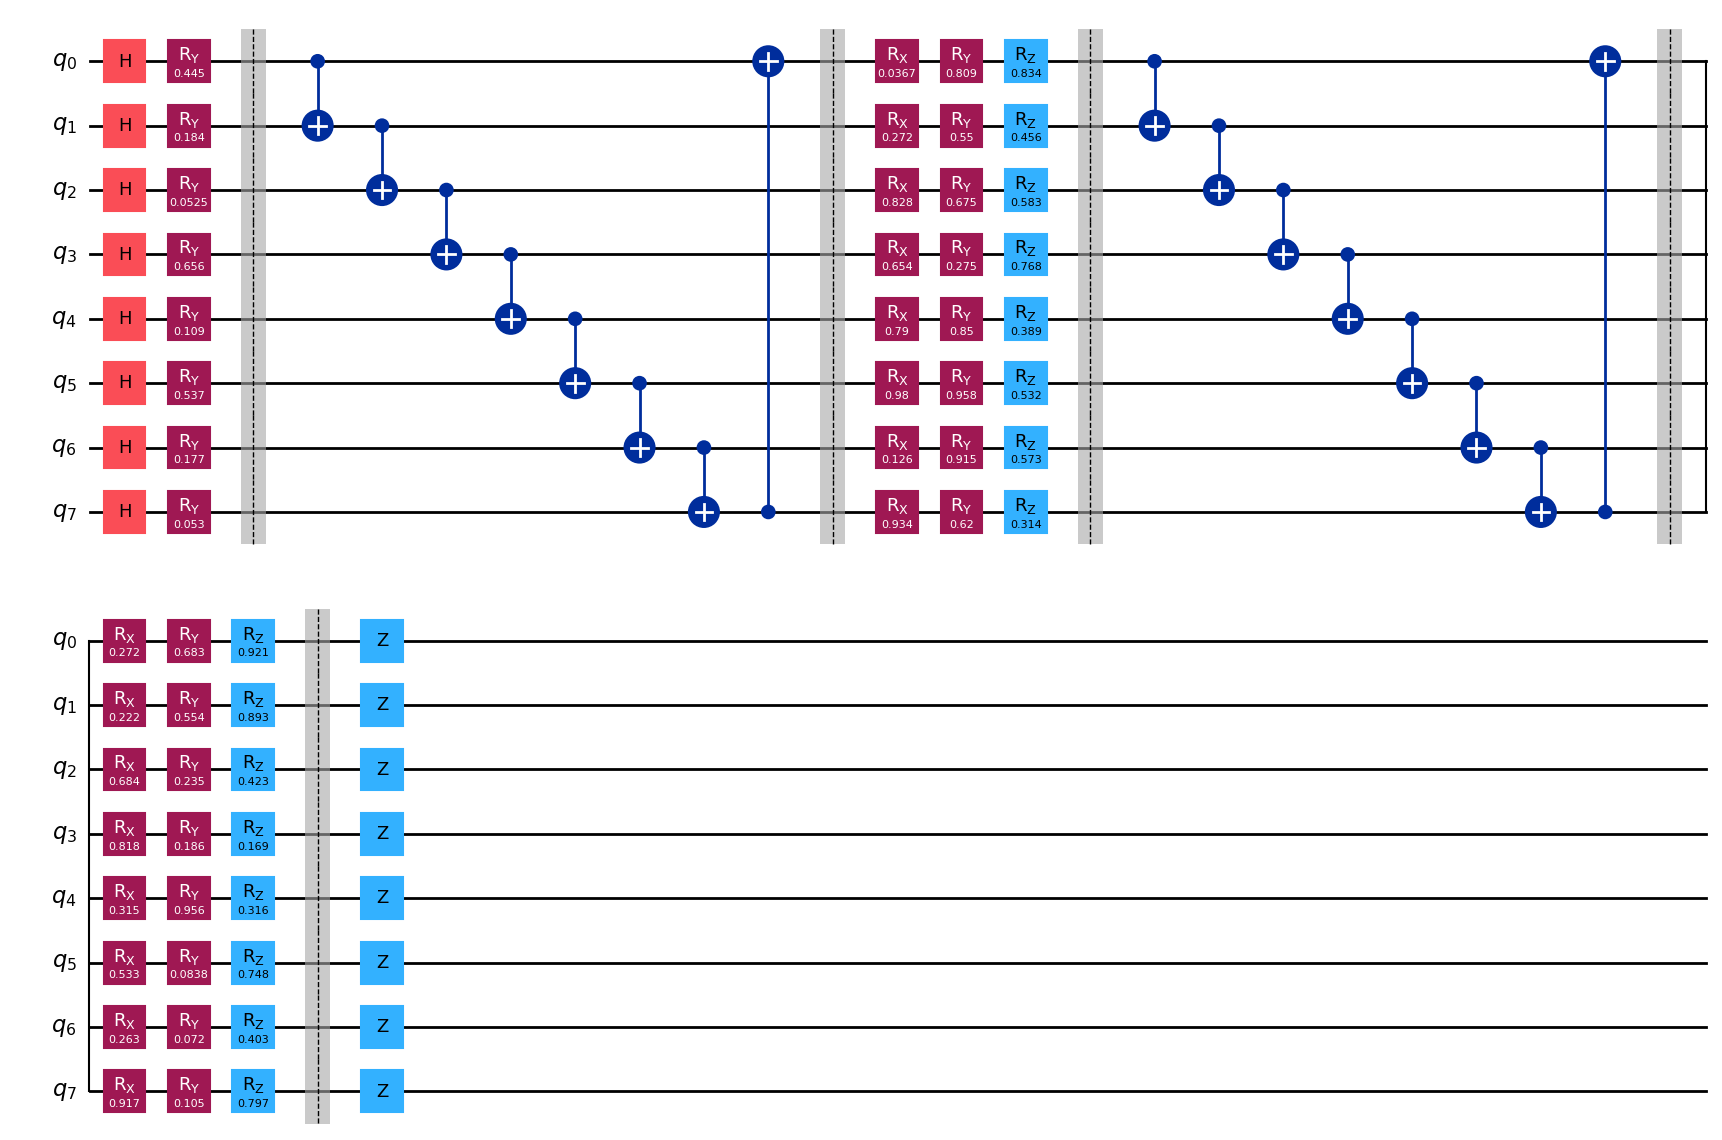

In [9]:
dev=qml.device("qiskit.aer",wires=nqubits)
input=np.random.rand(nqubits)
nlayers=2
weights=np.random.rand(nlayers,nqubits,3)

qc=QuantumCircuit(nqubits)
for i in range(nqubits):
    qc.h(i)
    qc.ry(input[i],i)
qc.barrier()
for i in range(nlayers):
    for j in range(nqubits-1):
        qc.cx(j,j+1)
    qc.cx(nqubits-1,0)
    qc.barrier()
    for j in range(nqubits):
        qc.rx(weights[i][j][0],j)
        qc.ry(weights[i][j][1],j)
        qc.rz(weights[i][j][2],j)
    qc.barrier()

for i in range(nqubits):
    qc.z(i)

qc.draw("mpl")
